# Imports

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import logging
import warnings

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

warnings.simplefilter('ignore')

In [3]:
print(tf.__version__)
tfds.disable_progress_bar()

1.15.3


# Load Dataset

In [4]:
ds, info = tfds.load('deep_weeds', with_info=True)

    'image': Image(shape=(256, 256, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=9),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


In [5]:
info.description

'The DeepWeeds dataset consists of 17,509 images capturing eight different weed species native to Australia in situ with neighbouring flora.The selected weed species are local to pastoral grasslands across the state of Queensland.The images were collected from weed infestations at the following sites across Queensland: "Black River", "Charters Towers",  "Cluden", "Douglas", "Hervey Range", "Kelso", "McKinlay" and "Paluma".'

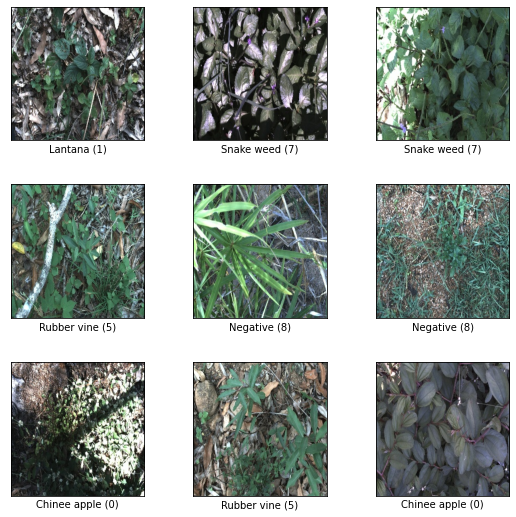

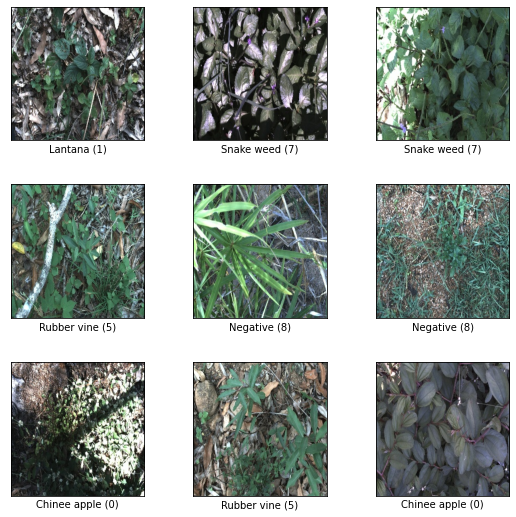

In [6]:
tfds.show_examples(ds['train'], info)

In [7]:
(train_data, valid_data, test_data), info = tfds.load('deep_weeds', 
                                     split=['train[:60%]','train[60%:80%]', 'train[80%:]'], 
                                     with_info=True, 
                                     as_supervised=True)

    'image': Image(shape=(256, 256, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=9),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(256, 256, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=9),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(256, 256, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=9),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph te

In [8]:
num_classes = info.features['label'].num_classes
img_size = info.features['image'].shape[0]

num_train = round(info.splits['train'].num_examples * 0.6)
num_valid = round(info.splits['train'].num_examples * 0.2)
num_test = round(info.splits['train'].num_examples * 0.2)

print("Classes:", num_classes)
print("Image Size: (%s, %s)" % (img_size, img_size))
print("Training Examples:", num_train)
print("Validation Examples:", num_valid)
print("Testing Examples:", num_test)

Classes: 9
Image Size: (256, 256)
Training Examples: 10505
Validation Examples: 3502
Testing Examples: 3502


# Preprocess Image Batches

In [9]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images = tf.image.resize(images, (224, 224)) / 255.0
  return images, labels

In [10]:
train_batches = train_data.shuffle(num_train).map(normalize).cache().batch(64).repeat().prefetch(1)
valid_batches = valid_data.shuffle(num_valid).map(normalize).cache().batch(64).repeat().prefetch(1)
test_batch = test_data.map(normalize).cache().batch(64).prefetch(1)

In [11]:
test_batch = train_batches.take(1)
print(test_batch)

<TakeDataset shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int64)>


# Build Model

In [12]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224, 3))
feature_extractor.trainable = False

In [13]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 2,918,473
Trainable params: 660,489
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('weeds_weights.h5', 
                                                      save_best_only=True, 
                                                      save_weights_only=True)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Train Model

In [15]:
history = model.fit(train_batches,
                    validation_data=valid_batches,
                    epochs=100,
                    steps_per_epoch=num_train//64,
                    validation_steps=num_valid//64,
                    callbacks=[model_checkpoint, early_stopping])

Train on 164 steps, validate on 54 steps
Epoch 1/100
164/164 [==============================] - 20s 120ms/step - loss: 1.1292 - acc: 0.6265 - val_loss: 0.7987 - val_acc: 0.7216
Epoch 2/100
164/164 [==============================] - 12s 72ms/step - loss: 0.7444 - acc: 0.7463 - val_loss: 0.6571 - val_acc: 0.7717
Epoch 3/100
164/164 [==============================] - 12s 71ms/step - loss: 0.6280 - acc: 0.7872 - val_loss: 0.5880 - val_acc: 0.7977
Epoch 4/100
164/164 [==============================] - 11s 69ms/step - loss: 0.5529 - acc: 0.8121 - val_loss: 0.5506 - val_acc: 0.8050
Epoch 5/100
164/164 [==============================] - 11s 70ms/step - loss: 0.5025 - acc: 0.8318 - val_loss: 0.5241 - val_acc: 0.8148
Epoch 6/100
164/164 [==============================] - 11s 70ms/step - loss: 0.4644 - acc: 0.8445 - val_loss: 0.5037 - val_acc: 0.8261
Epoch 7/100
164/164 [==============================] - 12s 71ms/step - loss: 0.4263 - acc: 0.8595 - val_loss: 0.4915 - val_acc: 0.8293
Epoch 8/100
1

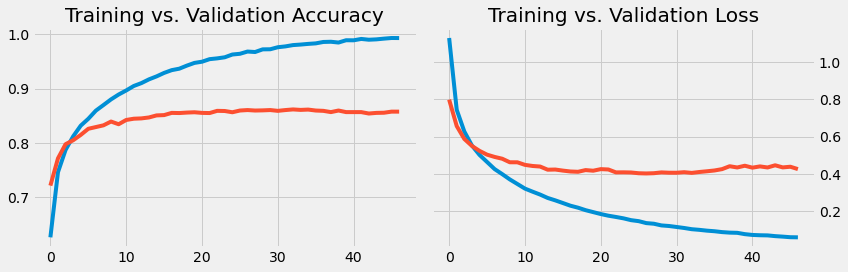

In [16]:
plt.style.use('fivethirtyeight')

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(acc, label='Training Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy')
axs[0].set_title('Training vs. Validation Accuracy')

axs[1].plot(loss, label='Training Loss')
axs[1].plot(val_loss, label='Validation Loss')
axs[1].yaxis.tick_right()
axs[1].set_title('Training vs. Validation Loss')

fig.tight_layout()

# Load and Evaluate Model

In [17]:
model.load_weights("weeds_weights.h5")

In [18]:
results = model.evaluate(test_batch, steps=num_test//64)
dict(zip(model.metrics_names, results))

 1/54 [..............................] - ETA: 1:44 - loss: 0.0651 - acc: 1.0000

{'loss': 0.0012060279647509258, 'acc': 1.0}